# Assignment 1
- s113604 Mark Ian Svenningsen
- s113627 Casper Clemmensen
- s146893 Kasper Hoa Quoc Duong

## Assignment 1A: Anscombe's quartet

## Assignment 1B: Slicing data

### We'll be combining information about PdDistrict and Category to explore differences between SF's neighborhoods. First, simply list the names of SF's 10 police districts.

We begin by loading the cvs file. Containing all the crime records, and parse it into a dictonary, for easy access.

Note that we ignore any crime that do not have a district.

In [1]:
from csv import reader

def parseCrimeCsv(row):
    return {
        'IncidntNum': line[0],
        'Category': line[1],
        'Descript': line[2],
        'DayOfWeek': line[3],
        'Date': line[4],
        'Time': line[5],
        'PdDistrict': line[6],
        'Resolution': line[7],
        'Address': line[8],
        'X': line[9],
        'Y': line[10],
        'Location': line[11],
        'PdId': line[12]
    }

with open('../SFPD_Incidents_-_from_1_January_2003.csv', 'r') as infile:    
    data = [parseCrimeCsv(line) for line in list(reader(infile))[1:] if not line[6] == '']

Now that the file have been loaded into memory we can extract all the districts.
We do this by taking value ` PdDistrict ` of all records, and insert them into a set.

In [2]:
PdDistrictSet = set([i['PdDistrict'] for i in data])
PdDistrictSet

{'BAYVIEW',
 'CENTRAL',
 'INGLESIDE',
 'MISSION',
 'NORTHERN',
 'PARK',
 'RICHMOND',
 'SOUTHERN',
 'TARAVAL',
 'TENDERLOIN'}

### Which has the most crimes? Which has the most focus crimes?

If we being finding the district with the most overall crimes.
We begin with creating a `Counter` object, were we input the districts of the dataset.
This object, helps us counting the occorences of the given values.

Lastly we call the ` most_common(1) ` on the `Counter` to extract the district with the most crimes overall.

In [7]:
from collections import Counter

DistrictCrimeCounter = Counter([d['PdDistrict'] for d in data])

DistrictCrimeCounter.most_common(1)

[('SOUTHERN', 335978)]

By looking at hthe output above, we can se that **Southern** is the district with the most crimes overall with a total count of 335978 crimes from Jan 2003 to Jan 2016.

** Which has the most focus crimes?**
To do this we first define the focus crimes, these are taken from the exercises from [week 3](http://nbviewer.jupyter.org/github/suneman/socialdataanalysis2016/blob/master/lectures/Week3.ipynb):

In [4]:
focuscrimes = set([
        'WEAPON LAWS',
        'PROSTITUTION',
        'DRIVING UNDER THE INFLUENCE',
        'ROBBERY',
        'BURGLARY',
        'ASSAULT',
        'DRUNKENNESS',
        'DRUG/NARCOTIC',
        'TRESPASS',
        'LARCENY/THEFT',
        'VANDALISM',
        'VEHICLE THEFT',
        'STOLEN PROPERTY',
        'DISORDERLY CONDUCT'
    ])

Now that we have defined the focus crimes, we can filter our dataset. So that we get a new data set that only contains the records for these crimes. We do this by utilizing the build in filter function.

Then we do the same operatios a above, to get the district with the most focus crimes.

In [8]:
data_filtered_for_focus_crimes = filter(lambda c: c['Category'] in list(focuscrimes), data)

       
most_common_focus_crime_by_dist = Counter([d['PdDistrict'] for d in data_filtered_for_focus_crimes])
most_common_focus_crime_by_dist.most_common(1)

[('SOUTHERN', 191521)]

We see that it is again the district south that have the most focus crimes, just as it also had with all crimes.
However this time around we are down to 191521 crimes commited between Jan 2003 and Jan 2016.

### Next, we want to generate a slightly more complicated graphic. I'm interested to know if there are certain crimes that happen much more in certain neighborhoods than what's typical. Below I describe how to get that plot going

#### First, we need to calculate the relative probabilities of seeing each type of crime in the dataset as a whole. That's simply a normalized version of this plot. Let's call it P(crime).

Firstly we have to create a `Counter` for the categories. Then we can use list comprehention, over the output of `most common`, to create a nicely structred dataset. 

In [55]:
from __future__ import division

# DistrictCrimeCounter

CatetoryCrimeCounter = Counter([d['Category'] for d in data])

p_crime = {}
for k,v in CatetoryCrimeCounter.most_common():
    p_crime[k] = v/len(data)

p_crime

{'ARSON': 0.0017349745013750567,
 'ASSAULT': 0.0875342429177903,
 'BAD CHECKS': 0.0004571062398205751,
 'BRIBERY': 0.0003551117400475262,
 'BURGLARY': 0.04178837476303634,
 'DISORDERLY CONDUCT': 0.004770779376818946,
 'DRIVING UNDER THE INFLUENCE': 0.002626224868501856,
 'DRUG/NARCOTIC': 0.05924919232104237,
 'DRUNKENNESS': 0.004795343497183136,
 'EMBEZZLEMENT': 0.0013745227351614022,
 'EXTORTION': 0.00032574159613382107,
 'FAMILY OFFENSES': 0.0005751208180920087,
 'FORGERY/COUNTERFEITING': 0.011604944864229834,
 'FRAUD': 0.019067631431394012,
 'GAMBLING': 0.00016340480068352336,
 'KIDNAPPING': 0.0025781646330067017,
 'LARCENY/THEFT': 0.20380476864336636,
 'LIQUOR LAWS': 0.0020521720556430727,
 'LOITERING': 0.0012511681307238406,
 'MISSING PERSON': 0.029413932128267428,
 'NON-CRIMINAL': 0.10625637465623582,
 'OTHER OFFENSES': 0.1426449149600833,
 'PORNOGRAPHY/OBSCENE MAT': 2.4564120364189783e-05,
 'PROSTITUTION': 0.00831068272234534,
 'RECOVERED VEHICLE': 0.0033887806050249647,
 'ROBBE

#### Next, we calculate that same probability distribution but for each PD district, let's call that P(crime|district).

Now we do the same, however we do it per district instead.

Our result is a dictonary, with the district as key, followed by a list, containing dictionaries again, with the crime category as key and properbility as value.

In [58]:
p_crime_district = {}
l = len(data)
for district in list(PdDistrictSet):
    counter = Counter([d['Category'] for d in data if d['PdDistrict'] == district])
    p_crime_district[district] = {}
    for k,v in counter.most_common():
            p_crime_district[district][k] = v / len(list(counter.elements()));
    
    
p_crime_district

{'BAYVIEW': {'ARSON': 0.004446580305134691,
  'ASSAULT': 0.10975448750785545,
  'BAD CHECKS': 0.0003538252736864897,
  'BRIBERY': 0.0006337169080952054,
  'BURGLARY': 0.044397150386303263,
  'DISORDERLY CONDUCT': 0.002476776915805428,
  'DRIVING UNDER THE INFLUENCE': 0.002091265796714178,
  'DRUG/NARCOTIC': 0.04878035900062844,
  'DRUNKENNESS': 0.00274610660174589,
  'EMBEZZLEMENT': 0.0012938386873610444,
  'EXTORTION': 0.00020595799513094175,
  'FAMILY OFFENSES': 0.0008343939289920205,
  'FORGERY/COUNTERFEITING': 0.008502368516944006,
  'FRAUD': 0.010113065658352653,
  'GAMBLING': 0.0002693296859404623,
  'KIDNAPPING': 0.0037072439123569515,
  'LARCENY/THEFT': 0.11580120300593054,
  'LIQUOR LAWS': 0.0013255245327658046,
  'LOITERING': 0.0005016925522420376,
  'MISSING PERSON': 0.05471089306555273,
  'NON-CRIMINAL': 0.07021055244271464,
  'OTHER OFFENSES': 0.18928595947380372,
  'PORNOGRAPHY/OBSCENE MAT': 2.640487117063356e-05,
  'PROSTITUTION': 0.0006918076246705992,
  'RECOVERED VEHI

#### Now we look at the ratio P(crime|district)/P(crime). That ratio is equal to 1 if the crime occurs at the same level within a district as in the city as a whole. If it's greater than one, it means that the crime occurs more frequently within that district. If it's smaller than one, it means that the crime is rarer within the district in question than in the city as a whole. 

#### For each district plot these ratios for the 14 focus crimes. My plot looks like this

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000003975E8D0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x000000015F2F86A0>]], dtype=object)

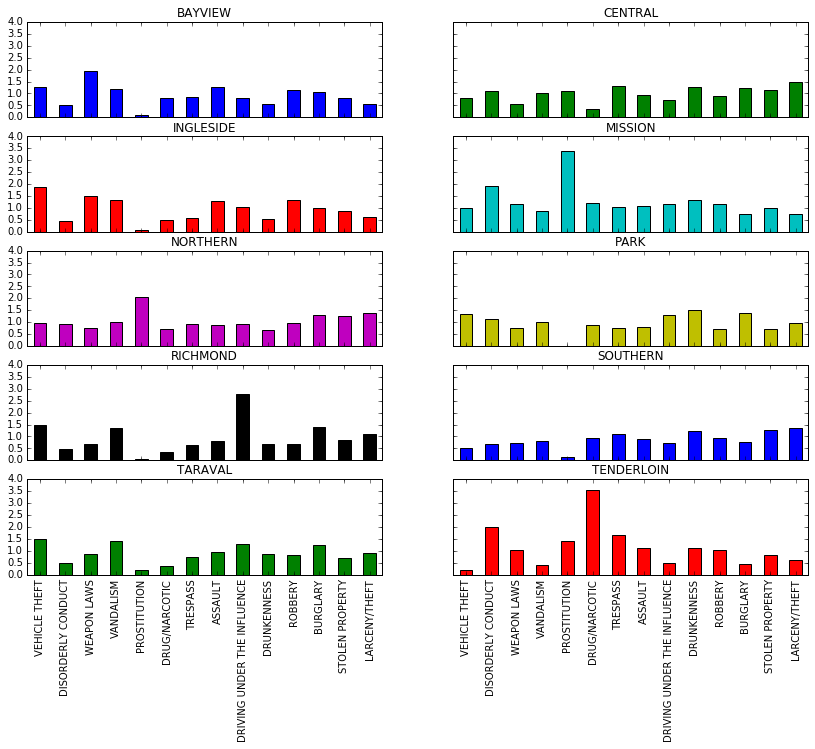

In [60]:
import pandas as pd
%matplotlib inline

def calcRatioForDistrict(districtCounter, overAllCounter, district):
    ys = []
    xs = []
    for fc in list(focuscrimes):
        ys.append(districtCounter[fc] / overAllCounter[fc])
        xs.append(fc)
    return pd.Series(ys, index=xs)
    
series = {}
for district in list(PdDistrictSet):
    series[district] = calcRatioForDistrict(p_crime_district[district], p_crime, district)

df = pd.DataFrame(series)
df.plot(kind="bar", subplots=True, figsize=(14,14),layout=(7,2), legend=False,sharey=True)

#### Comment on the top crimes in Tenderloin, Mission, and Richmond. Does this fit with the impression you get of these neighborhoods on Wikipedia?

#### Even though we only plotted the ratios for our 14 focus crimes, I asked you to calculate the ratios based on all crime categories. Why do you think I wanted to include all crime types in the calculation?

## Assignment 1C: KNN

## Assignment 1D: Multiple regression and the Red Baron